In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.figure_factory as ff
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


SEED = 42

In [2]:
projects = pd.read_csv("../data/nrao_projects.csv")
projects = projects.set_index('project_code')

In [3]:
line_projects = projects.query('fs_type == "line"')
line_projects.shape

(3628, 12)

In [4]:
measurements = pd.read_csv('../../nrao_measurements.csv')
measurements = measurements.set_index('project_code')
measurements = measurements[measurements.fs_type == 'line']

## Remove outliers from projects and measurements

See 'Identifying_High_Measurement_Projects.ipynb' in 'data' folder

From this notebook, any project with > 26.5 measurements is an outlier

In [5]:
project_measurements = measurements.groupby(measurements.index)\
    .project_title.count()\
        .sort_values(ascending=False)\
        .to_frame()
project_measurements.columns = ['measurement_count']
project_measurements.head()

measurement_count
project_code                     
2017.1.00161.L                289
2017.1.00886.L                283
2021.2.00052.S                265
2023.1.00963.S                253
2022.1.00224.S                188

In [6]:
outliers = project_measurements[project_measurements.measurement_count > 26.5]

In [7]:
measurements = measurements.loc[~measurements.index.isin(outliers.index)]
line_projects = line_projects.loc[~line_projects.index.isin(outliers.index)]

### Sort frames by index

In [8]:
measurements = measurements.sort_index(ascending=True)
line_projects = line_projects.sort_index(ascending=True)

### Use KNN to find $\epsilon$ for DBSCAN
The DBSCAN papers suggest using the elbow method with $k=2*\text{num dimensions}-1$ to find the optimal $\epsilon$

In our case since we're only using 1 dimension we use $k=2$

In [9]:
X = np.array(measurements.med_freq)
X = X.reshape(-1, 1)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot
fig = px.scatter(
    distances, 
    title='Distance Curve')
fig.update_xaxes(title_text='Distances')
fig.update_yaxes(title_text='Distance threashold (espsilon)')
fig.show()

In [10]:
#db = DBSCAN(eps=0.145, min_samples=2).fit(list(zip(measurements.med_freq)))
db = DBSCAN(eps=0.05, min_samples=10).fit(list(zip(measurements.med_freq)))

### Summarize and visualize DBSCAN results

In [11]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_points = len(list(labels))
n_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Total number of measurements: %d" % n_points)
print("Estimated number of noise measurements: %d" % n_noise)
print(f"Noise percentage: {round(list(labels).count(-1)/labels.shape[0], 3)}")
print(f'Signal to noise ratio: {1-round(list(labels).count(-1)/labels.shape[0], 3)}')

Estimated number of clusters: 320
Total number of measurements: 25051
Estimated number of noise measurements: 5763
Noise percentage: 0.23
Signal to noise ratio: 0.77


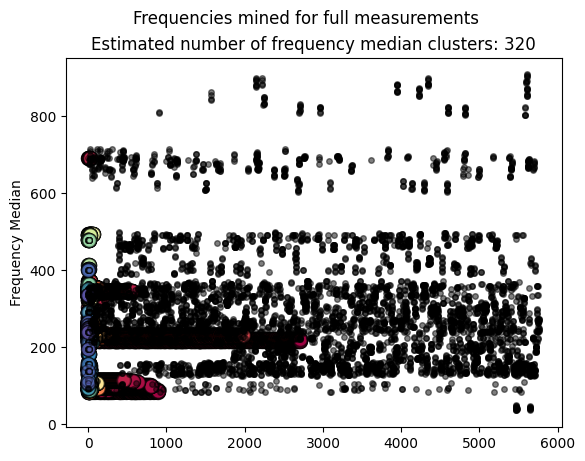

In [12]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
        alpha=0.5
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=4,
        alpha=0.5
    )

plt.title(f"Estimated number of frequency median clusters: {n_clusters}")
plt.ylabel('Frequency Median')
plt.suptitle(f"Frequencies mined for full measurements")
plt.show()

### Assign labels to measurements for topic and describe clusters
We need to add one since 'noise' not accounted for by a DBSCAN cluster are labeled -1 and we will want to index an array later by cluster label.

In [13]:
measurements['cluster'] = db.labels_ + 1

In [14]:
measurements.groupby('cluster').count().project_title.sort_values(ascending=False).head(20)

cluster
0      5763
3      2715
39     1989
4       905
8       815
7       740
9       641
10      584
16      576
19      458
11      351
72      274
5       257
15      246
29      203
70      196
23      183
6       169
1       144
101     141
Name: project_title, dtype: int64

In [15]:
measurements.groupby('cluster').count().project_title.describe()

count     321.000000
mean       78.040498
std       382.229130
min         2.000000
25%        13.000000
50%        19.000000
75%        34.000000
max      5763.000000
Name: project_title, dtype: float64

In [16]:
measurements[measurements.cluster == 39].med_freq.describe()

count    1989.000000
mean      230.691757
std         0.745880
min       228.930000
25%       230.420000
50%       230.540000
75%       231.265000
max       232.310000
Name: med_freq, dtype: float64

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='med_freq', ylabel='Density'>

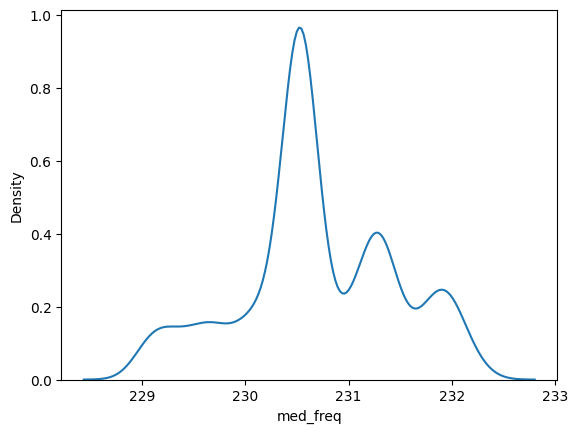

In [17]:
sns.kdeplot(measurements[measurements.cluster == 39].med_freq)

### Create ground-truth vectors for DBSCAN cluster by project

#### Group by project id

In [18]:
proj_meas = measurements.groupby('project_code').agg({
    'cluster': lambda x: x.to_list()
})

In [19]:
def generate_gt(frame:pd.DataFrame, label_column:str, labs:np.array, normalize=True): 
    '''
    Function that generates ground truth vectors for projects by taking a data frame,
    a string representing the column name that has a list of labels for each measurement,
    and the raw lables from a clustering algorithm

    PARAMETERS:
    
    frame: `pd.DataFrame` indexed by project_code that has a column with list of measurment labels

    label_column: `str` name of column to base ground truth vector off of

    labs: `np.ndarray` of lables generated by clustering algorithm

    normalize: `bool` to normalize vector by sum of values to get probability vector. Defaults to `True`

    OUTPUTS:

    gt_list: `list` of `np.array` ground truth vectors
    '''  
    # gt_list = []
    # for proj in frame.index.values:
    #     arr = np.zeros(len(set(list(labs))))
    #     proj_labs = pd.Series(frame.loc[proj][label_column]).value_counts()
    #     for idx in proj_labs.index:
    #         arr[idx] = proj_labs[idx]
    #     if normalize:
    #         arr = arr/arr.sum()
    #     gt_list.append(np.array(arr))
    # return gt_list

    gt_dict = {}
    for proj in frame.index.values:
        arr = np.zeros(len(set(list(labs))))
        proj_labs = pd.Series(frame.loc[proj][label_column]).value_counts()
        for idx in proj_labs.index:
            arr[idx] = proj_labs[idx]
        if normalize:
            arr = arr/arr.sum()
        gt_dict[proj] = np.array(arr)
    return gt_dict

#### Check that we ground truth vectors for number of projects

In [20]:
ground_truth = generate_gt(proj_meas, 'cluster', db.labels_, normalize=True)
len(ground_truth)

3284

In [21]:
gt_frame = pd.DataFrame(ground_truth).sort_index(ascending=True).T
gt_frame

0       1     2    3      4       5     6      7    \
2011.0.00010.S  0.050000  0.1000  0.05  0.2  0.200  0.0500  0.05  0.050   
2011.0.00017.S  0.062500  0.0625  0.00  0.0  0.125  0.0625  0.00  0.125   
2011.0.00028.S  0.000000  0.0000  0.00  0.0  0.000  0.0000  0.00  0.000   
2011.0.00039.S  1.000000  0.0000  0.00  0.0  0.000  0.0000  0.00  0.000   
2011.0.00046.S  0.000000  0.0000  0.00  0.0  0.000  0.0000  0.00  0.000   
...                  ...     ...   ...  ...    ...     ...   ...    ...   
2023.1.01710.S  0.000000  0.0000  0.00  0.0  0.000  0.0000  0.00  0.000   
2023.1.01720.S  0.166667  0.0000  0.00  0.5  0.000  0.0000  0.00  0.000   
2023.1.01721.S  0.000000  0.0000  0.00  0.0  0.000  0.0000  0.00  0.000   
2023.A.00003.S  0.500000  0.0000  0.00  0.0  0.000  0.0000  0.00  0.000   
2023.A.00009.S  0.000000  0.0000  0.00  0.0  0.000  0.0000  0.00  0.000   

                  8      9    ...  311  312  313  314  315  316  317  318  \
2011.0.00010.S  0.050  0.100  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2011.0.00017.S  0.125  0.125  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2011.0.00028.S  0.000  0.000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2011.0.00039.S  0.000  0.000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2011.0.00046.S  0.250  0.000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...               ...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023.1.01710.S  0.000  0.000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023.1.01720.S  0.000  0.000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023.1.01721.S  0.000  0.000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023.A.00003.S  0.000  0.000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023.A.00009.S  0.000  0.000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                319  320  
2011.0.00010.S  0.0  0.0  
2011.0.00017.S  0.0  0.0  
2011.0.00028.S  0.0  0.0  
2011.0.00039.S  0.0  0.0  
2011.0.00046.S  0.0  0.0  
...             ...  ...  
2023.1.01710.S  0.0  0.0  
2023.1.01720.S  0.0  0.0  
2023.1.01721.S  0.0  0.0  
2023.A.00003.S  0.0  0.0  
2023.A.00009.S  0.0  0.0  

[3284 rows x 321 columns]

### Add ground truth labels to projects

In [22]:
gt_frame = gt_frame.apply(lambda x: x.to_list(), axis=1).to_frame()

In [23]:
gt_frame.columns = ['gt_vec']
gt_frame.head()

gt_vec
2011.0.00010.S  [0.05, 0.1, 0.05, 0.2, 0.2, 0.05, 0.05, 0.05, ...
2011.0.00017.S  [0.0625, 0.0625, 0.0, 0.0, 0.125, 0.0625, 0.0,...
2011.0.00028.S  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2011.0.00039.S  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2011.0.00046.S  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25,...

#### Generate small dataframe to be fed to BERT

In [24]:
bert_input = pd.merge(line_projects[['standardized_text']], gt_frame, left_index=True, right_index=True)
bert_input.head()

standardized_text  \
project_code                                                        
2011.0.00010.S  the physics and chemisty of gas in centaurus a...   
2011.0.00017.S  expanding the frontiers of chemical complexity...   
2011.0.00028.S  the effect of extreme environment on protoplan...   
2011.0.00039.S  the view of the cool dust in an extreme low me...   
2011.0.00046.S  the first insight into the resolved molecular ...   

                                                           gt_vec  
project_code                                                       
2011.0.00010.S  [0.05, 0.1, 0.05, 0.2, 0.2, 0.05, 0.05, 0.05, ...  
2011.0.00017.S  [0.0625, 0.0625, 0.0, 0.0, 0.125, 0.0625, 0.0,...  
2011.0.00028.S  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2011.0.00039.S  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2011.0.00046.S  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25,...